# Energy A.I. Hackathon 2023 Workflow - TexasBBQ

#### Authors: Ethan Froelich, Rahul Nandakumar, Soorya Sriram, Ziyu Dai
#### Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Operations Research and Industrial Engineering, Walker School of Mechanical Engineering


#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

1. What is the problem?
2. What did your team do to address the problem?
3. What did your team learn?
4. What does your team recommend going forward?

___

### Workflow Goal

1-2 sentences 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap            # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
cmap = plt.cm.inferno  

### Load Data

In [2]:
df_dailydata = pd.read_csv("dailyData.csv")
well_data = pd.read_csv("wellData.csv")
df_solutions = pd.read_csv("solution.csv")

### Functions
The following functions will be used in the workflow

In [3]:
def partial_corr(C):                                    # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                         # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                  # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):             # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):              # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):           # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):             # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

### Custom Color Map
for visualizations

In [4]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)            # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                           # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                            # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                      # assign as listed colormap
  
my_colormap = plt.cm.get_cmap('inferno', 256)           # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                              # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                           # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors)                       # assign as listed colormap

### Data Checking
We need to understand what we are working with and what values are missing.

In [5]:
wellids_unique = df_dailydata["Well_ID"].value_counts()
print(wellids_unique.index)

well_df = pd.DataFrame(df_dailydata["Well_ID"].unique()) #what are the unique values? #IS THIS LINE NECESSARY?
well_df = well_df.sort_values(by=[0], ascending=True) # s
well_df = well_df.rename(columns={0:'Well_Id'}) # What does this line do practically?
well_df.reset_index(inplace=True) # reset column index 
well_df = well_df.drop('index', axis = 1) # get rid of index
well_df

well_ids = np.asarray(well_df["Well_Id"]) 

Int64Index([353,  85,  81, 330, 158, 115, 351, 116, 252,  50,
            ...
            240,  97,  96, 109,  32,  61,  20, 143, 123, 341],
           dtype='int64', length=145)


Individual Count of Days of each Pump for Each Well

In [6]:
dict = {}
for v in well_ids:
    dict[v] = df_dailydata[df_dailydata["Well_ID"] == v]["AL_Key"].value_counts().to_dict()
dict

{0: {'ESP_1': 298},
 1: {'ESP_2': 341},
 4: {'ESP_2': 320},
 5: {'ESP_1': 338},
 6: {'ESP_1': 583},
 7: {'ESP_2': 278, 'ESP_1': 249},
 10: {'ESP_2': 454, 'ESP_1': 63},
 11: {'ESP_1': 529},
 12: {'ESP_1': 288},
 13: {'ESP_1': 231},
 14: {'ESP_1': 481},
 15: {'ESP_1': 295, 'ESP_2': 171},
 16: {'ESP_1': 233},
 17: {'ESP_1': 267},
 18: {'ESP_1': 231},
 19: {'ESP_1': 363},
 20: {'ESP_1': 38},
 21: {'ESP_1': 161},
 22: {'ESP_1': 443},
 23: {'ESP_1': 203},
 25: {'ESP_1': 357},
 27: {'ESP_1': 197},
 28: {'ESP_1': 337},
 29: {'ESP_3': 407},
 30: {'ESP_2': 132},
 32: {'ESP_1': 81},
 33: {'ESP_1': 135},
 35: {'ESP_1': 536},
 37: {'ESP_1': 176},
 40: {'ESP_1': 284},
 42: {'ESP_1': 562},
 43: {'ESP_1': 259},
 44: {'ESP_1': 376},
 45: {'ESP_1': 334},
 47: {'ESP_1': 263},
 48: {'ESP_1': 253},
 49: {'ESP_1': 323},
 50: {'ESP_1': 405, 'ESP_2': 257},
 51: {'ESP_1': 294},
 52: {'ESP_2': 385},
 53: {'ESP_2': 372},
 54: {'ESP_2': 298},
 55: {'ESP_1': 137},
 59: {'ESP_1': 425},
 60: {'ESP_1': 345},
 61: {'E

In [7]:
#Converting object type in DailyData (ESP) to numerical data
# daily data
df_dailydata["AL_Key"] = df_dailydata["AL_Key"].replace("ESP_1", 1) #in order to apply the next method, must have integers
df_dailydata["AL_Key"] = df_dailydata["AL_Key"].replace("ESP_2", 2)
df_dailydata["AL_Key"] = df_dailydata["AL_Key"].replace("ESP_3", 3)
df_dailydata["AL_Key"] = df_dailydata["AL_Key"].replace("ESP_4", 4)
df_dailydata["AL_Key"] = df_dailydata["AL_Key"].replace("ESP_5", 5)
df_dailydata["Unique_identifier"] = (df_dailydata["AL_Key"].astype(str) + df_dailydata["Well_ID"].astype(str)).astype(int)
#df_dailydata.describe().transpose() # see what we are working withd

# well data
well_data = well_data.drop(columns='Unnamed: 0')
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_1", 1)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_2", 2)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_3", 3)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_4", 4)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_5", 5)

Exploratory Data Analysis

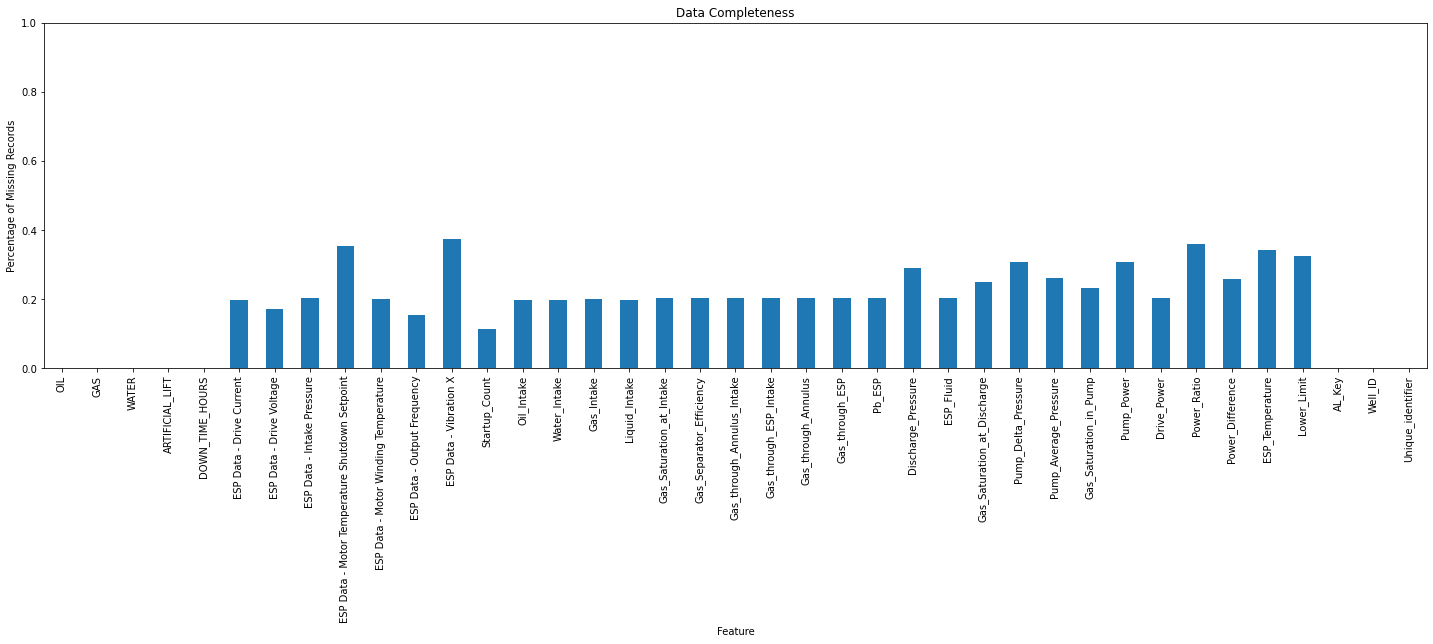

In [8]:
(df_dailydata.isnull().sum()/len(df_dailydata)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) 
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

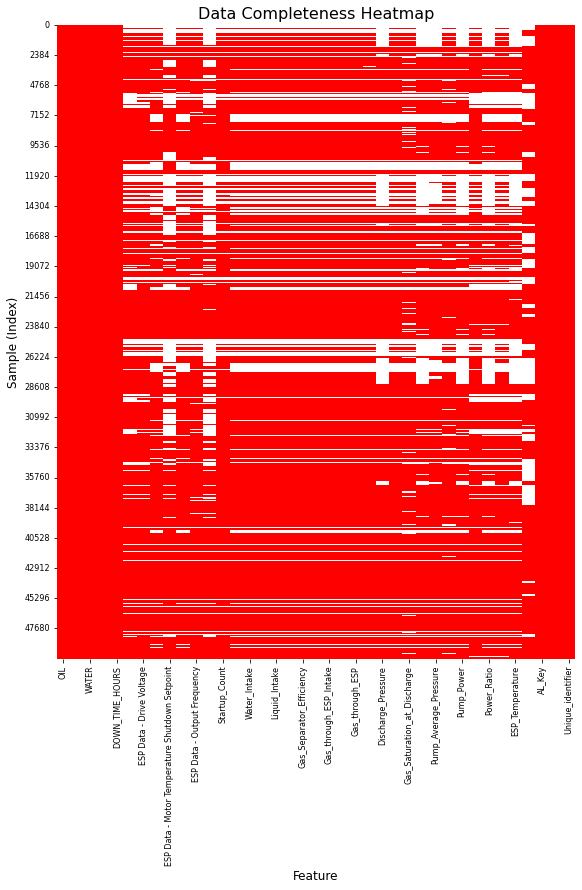

In [9]:
# figure out how much missing data there is
df_temp = df_dailydata.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black') # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [10]:
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_1", 1)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_2", 2)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_3", 3)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_4", 4)
well_data["AL_Key"] = well_data["AL_Key"].replace("ESP_5", 5)
well_data.head()

,Well_ID,AL_Key,Artificial_Lift_Type,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,Failure_Type,Failure_Type_Detail
0,345,2,ESP,9056.67,0,5.323174,NaN,NaN,NaN,NaN,1.713554,ELECTRICAL,MOTOR
1,29,3,ESP,8982.09,0,6.440650,NaN,NaN,NaN,NaN,2.789395,PUMP,MOTOR
2,327,1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.481680,ELECTRICAL,UNKNOWN
3,71,1,ESP,8930.11,0,5.614798,NaN,NaN,NaN,NaN,0.842038,ELECTRICAL,UNKNOWN
4,125,2,ESP,8616.41,348,26.061750,NaN,NaN,NaN,NaN,NaN,ELECTRICAL,PENETRATOR


In [11]:
#Combining AL_Key and Well ID as a primary unique identifier
well_data["Unique_identifier"] = (well_data["Well_ID"].astype(str) + well_data["AL_Key"].astype(str)).astype(int)

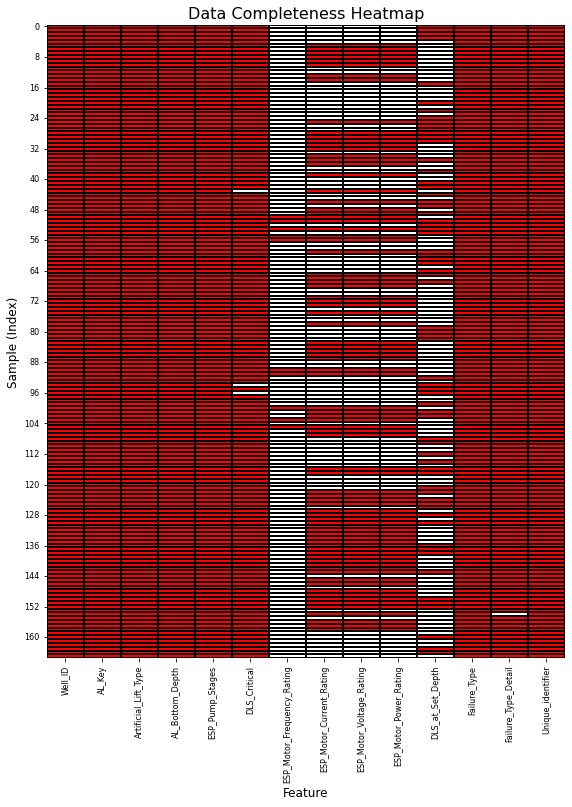

In [12]:
# see how much data we are missing
df_temp = well_data.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

Dropping of Columns and Inputation of Data in Well Data 

In [13]:
well_data_dropped = well_data.drop(['ESP_Motor_Frequency_Rating', 'Artificial_Lift_Type','Failure_Type', 'Failure_Type_Detail'], axis = 1)

In [14]:
df_knn = well_data_dropped.copy(deep=True)                         # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

In [15]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Well_ID                   166 non-null    float64
 1   AL_Key                    166 non-null    float64
 2   AL_Bottom_Depth           166 non-null    float64
 3   ESP_Pump_Stages           166 non-null    float64
 4   DLS_Critical              166 non-null    float64
 5   ESP_Motor_Current_Rating  166 non-null    float64
 6   ESP_Motor_Voltage_Rating  166 non-null    float64
 7   ESP_Motor_Power_Rating    166 non-null    float64
 8   DLS_at_Set_Depth          166 non-null    float64
 9   Unique_identifier         166 non-null    float64
dtypes: float64(10)
memory usage: 13.1 KB


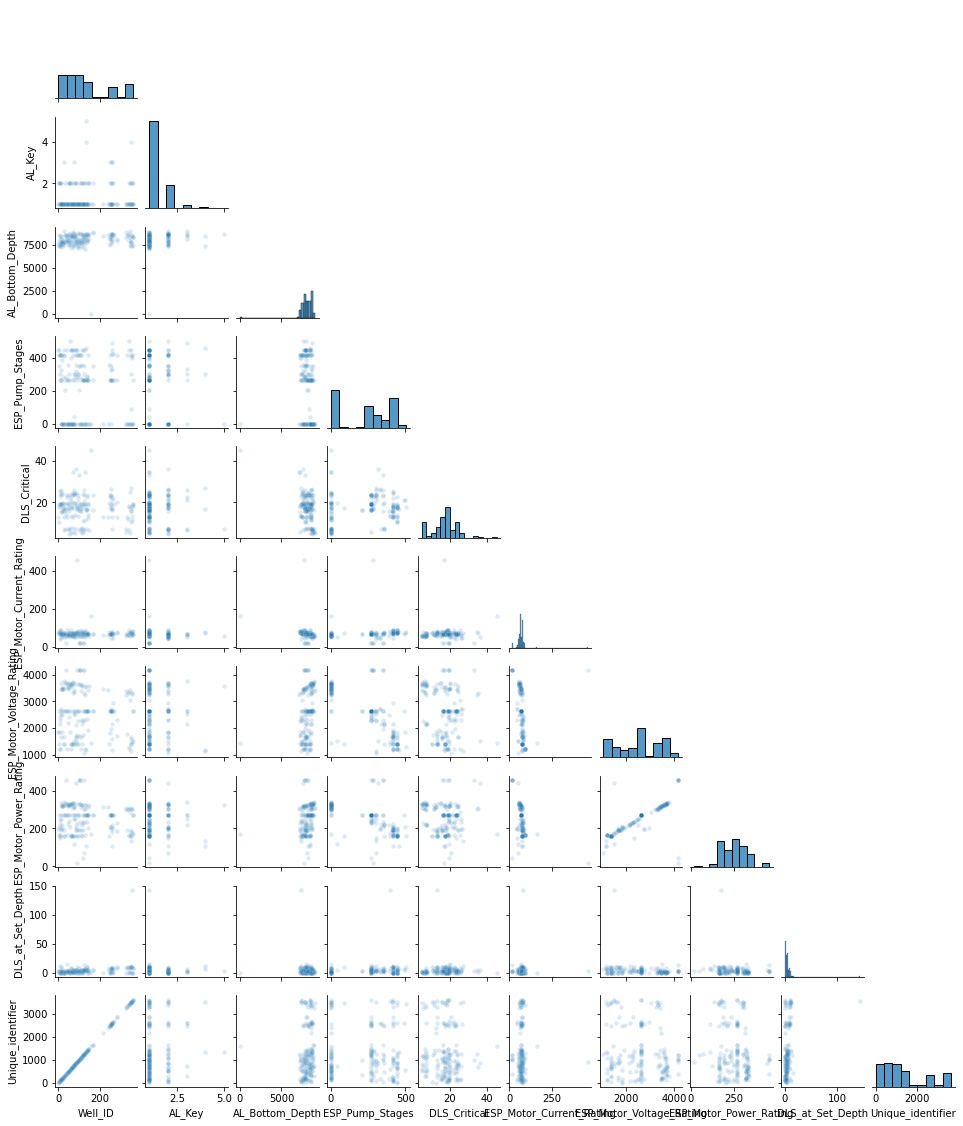

In [16]:
# use mice to carry out feature imputation
df_mice = well_data_dropped.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)

sns.pairplot(df_mice.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [17]:
imputed_dataset = df_mice
well_data_dropped["DLS_Critical"] = imputed_dataset["DLS_Critical"]
imputed_dataset["DLS_Critical"]

0       5.323174
1       6.440650
2       5.669751
3       5.614798
4      26.061750
         ...    
161    17.561921
162    12.231519
163    12.905506
164    12.924289
165    14.108933
Name: DLS_Critical, Length: 166, dtype: float64

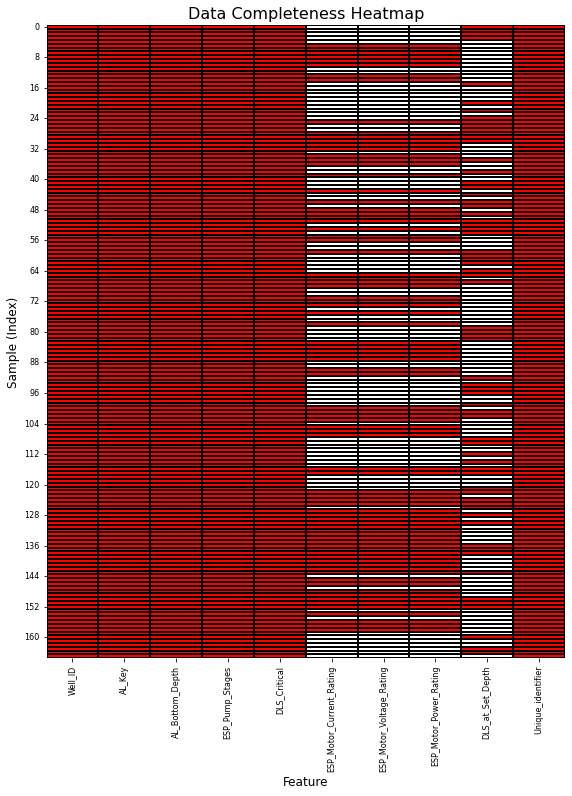

In [18]:
df_temp = well_data_dropped.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [19]:
well_data_lr = well_data_dropped.copy()
well_data_lr_dropped= well_data_lr.dropna()
well_data_lr_dropped = well_data_lr_dropped.drop(columns= ["Well_ID","AL_Key","Unique_identifier"])

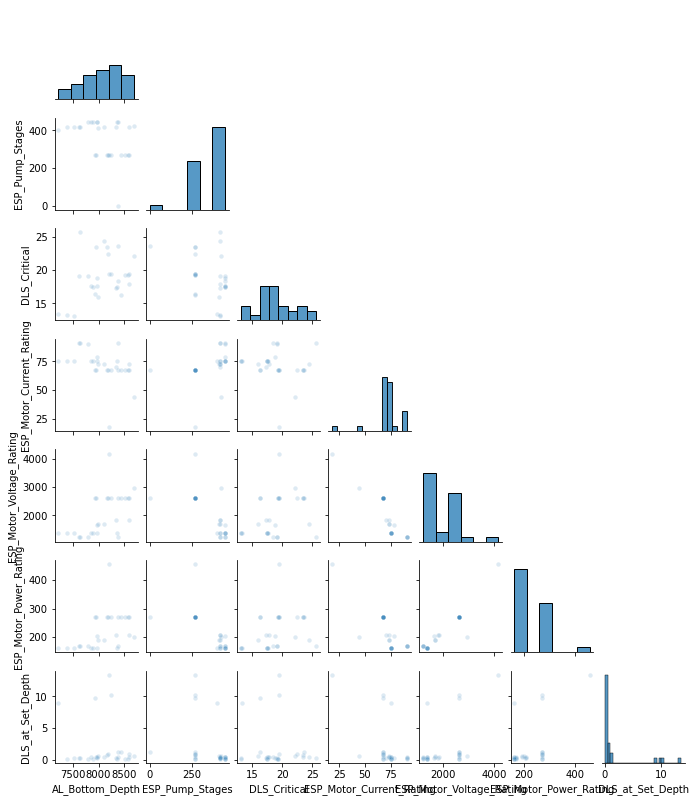

In [20]:
sns.pairplot(well_data_lr_dropped.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [ ]:
well_data_lr_final = well_data_lr.drop(columns= ["Well_ID","AL_Key","Unique_identifier"])
sns.pairplot(well_data_lr_final.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [ ]:
well_data_lr = well_data_lr_final.drop(columns=['ESP_Motor_Current_Rating', 'ESP_Motor_Voltage_Rating', 'ESP_Motor_Power_Rating'], axis=1)

### Regression Analysis
Regression Analysis was performed using Linear Regression, Polynomial Regression for degree 2 to 5, XGB Regressor to predict the 'DLS_at_Set_Depth' using the three features ("AL_Bottom_Depth", "ESP_Pump_Stages", "DLS_Critical"). It was found the R2 squure was negative or too large for the test set accuracy when an accuracy of 0.8 or above was acheived using the training set which composed of only the 67 rows that did not have 'NaN' values in the 'DLE_at_Set_Depth' column.

In [ ]:
well_data_lr = well_data_lr.drop(columns= ["DLS_at_Set_Depth"])

In [ ]:
col_names = ["AL_Bottom_Depth", "ESP_Pump_Stages", "DLS_Critical"]
well_data_lr

In [ ]:
#Convertion of Objects to numerical values using solution.csv values which is later used to remove from the welldata.csv
df_solutions["AL_Key"] = df_solutions["AL_Key"].replace("ESP_1", 1)
df_solutions["AL_Key"] = df_solutions["AL_Key"].replace("ESP_2", 2)
df_solutions["AL_Key"] = df_solutions["AL_Key"].replace("ESP_3", 3)
df_solutions["AL_Key"] = df_solutions["AL_Key"].replace("ESP_4", 4)
df_solutions["AL_Key"] = df_solutions["AL_Key"].replace("ESP_5", 5)

In [ ]:
#Combining columns to achive a single Primary Key
df_solutions["Unique_identifier"] = (df_solutions["AL_Key"].astype(str) + df_solutions["Well_ID"].astype(str)).astype(int)

In [ ]:
primary_key_solutions = df_solutions["Unique_identifier"].to_list()

# Daily Data Analysis
## Ranking Method - Pariwise Correlation Coefficient
Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.  

### Removing Features
The goal was to remove unnessesary features in order to simplify the ML model. Features that have greater than a 0.7 correlation coefficient were dropped, as well as features determined not import from domain expertise

In [ ]:
col_names =  ['ESP Data - Motor Temperature Shutdown Setpoint', 'ESP Data - Vibration X', 'Pump_Power','OIL', 'WATER', 
             'Oil_Intake', 'Gas_Intake', 'Water_Intake',"Gas_Saturation_at_Discharge", "Pump_Average_Pressure",
             "Liquid_Intake", "Discharge_Pressure", "ESP Data - Drive Current", "ESP Data - Output Frequency",
             "Gas_through_ESP",'Power_Ratio', 'Drive_Power', 'Gas_Separator_Efficiency', "Gas_through_ESP_Intake", 
            "Gas_through_Annulus_Intake", "ESP_Fluid","ESP Data - Intake Pressure","Gas_Saturation_in_Pump", 'Startup_Count', 
            'Gas_through_Annulus', 'AL_Key','Lower_Limit','Well_ID','ARTIFICIAL_LIFT', 'Pump_Delta_Pressure',"ESP_Temperature"]
df_dailydata.drop(col_names, axis =1, inplace = True)

In [ ]:
#Making a visualization


plt.subplot(111)                                        # plot correlation matrix with significance colormap
sns.heatmap(df_dailydata.iloc[:,:].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=3, wspace=0.4, hspace=0.4)
plt.show()

#as you can see below, there are not features that have strong correlation

In [ ]:
df_dailydata_copy = df_dailydata.copy()
primary_key_dailydata = df_dailydata["Unique_identifier"].unique()
primary_key_dailydata

After performing Feature selction using Correlation Heatmaps, Pairwise Plots and Histograms, we used Feature imputations techniques namely KNN and MICE to fill the missing 'NaN Values.

In [ ]:
df_temp = df_dailydata.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black') # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

Identified that if the number of 'NaN' values if above the thereshold value 0.3 for each Unique Primary Key, feature imputation shoukd not be perfomed so we dropped that Primary Key from our analysis. 

In [ ]:
keys = df_dailydata["Unique_identifier"].tolist()

for key in keys:
  dataframe = df_dailydata[df_dailydata["Unique_identifier"] ==  key]
  nans_in_volt_dataframe = dataframe['ESP Data - Drive Voltage'].isna().sum()
  nans_in_motor_dataframe = dataframe['ESP Data - Motor Winding Temperature'].isna().sum()
  nans_in_sat_dataframe = dataframe['Gas_Saturation_at_Intake'].isna().sum()
  nans_in_pb_dataframe = dataframe['Pb_ESP'].isna().sum()
  nans_in_power_diff_dataframe = dataframe['Power_Difference'].isna().sum()
  if(nans_in_volt_dataframe > int(dataframe.shape[0]*0.3) or nans_in_motor_dataframe > int(dataframe.shape[0]*0.3) or nans_in_sat_dataframe > int(dataframe.shape[0]*0.3) or nans_in_pb_dataframe > int(dataframe.shape[0]*0.3) or nans_in_power_diff_dataframe > int(dataframe.shape[0]*0.3)):
    df_dailydata_drop = df_dailydata[df_dailydata['Unique_identifier'] != key]


In [ ]:
df_dailydata_drop_copy = df_dailydata_drop.copy()

df_temp = df_dailydata_drop.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black') # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [ ]:
len(df_dailydata_drop['Unique_identifier'].unique())

Out of 165 combinations in DailyData.csv, we reduced the combination of PumpWells from 165 to 164. Performed Feature Imputation to obtain a perfect clean data.

In [ ]:
df_mice = df_dailydata_drop.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)

In [ ]:
# Master Final Data

df_dailydata_final = df_mice

In [ ]:
len(df_dailydata_final['Unique_identifier'].unique())

In [ ]:
df_temp = df_dailydata_final.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black') # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [ ]:
df_dailydata_final['Unique_identifier'] = df_dailydata_final['Unique_identifier'].astype(int)

In [ ]:
df_dailydata_final

In [ ]:
df_dailydata_final_copy = df_dailydata_final.copy()

Removal of the PumpWell combination present in the solutions.csv from our DailyData_final dataset

In [ ]:
solution_data_dropped = pd.DataFrame()
for i in range(len(primary_key_solutions)):
  solution_data_dropped = solution_data_dropped.append(df_dailydata_final_copy[df_dailydata_final_copy['Unique_identifier'] == primary_key_solutions[i]])

In [ ]:
solution_data_dropped

In [ ]:
for i in range(len(primary_key_solutions)):
  df_dailydata_final = df_dailydata_final[df_dailydata_final["Unique_identifier"]!=primary_key_solutions[i]]

In [ ]:
df_dailydata_final

In [ ]:
reduced_pk = df_dailydata_final['Unique_identifier'].astype(int).unique().tolist()
len(reduced_pk)

In [ ]:
orig_pk = df_dailydata['Unique_identifier'].unique().tolist()
len(orig_pk)

We idientified that 1 PumpWell Combination got removed due to the threshold limit and 40 PumpWell combinations is our test set. The remaining 124 PumpWell Combinations was our training set

In [ ]:
#drop_pk = df_dailydata_drop['Unique_identifier'].astype(int).unique().tolist()
#len(drop_pk)

In [ ]:
X = df_dailydata_final.iloc[:, 0:7]

In [ ]:
X

A simple Vector AutoRegression model for all the data features.

In [ ]:
X = df_dailydata_final.iloc[:, 0:7]

# Create a VAR model with 1 lag
model = VAR(endog=X)

# Fit the model
results = model.fit(maxlags=1)

# Print summary of the model
print(results.summary())

# Make predictions for the next 5 time steps
predictions = results.forecast(X.values[-1:], 5)

# Print the predictions
print(predictions)


In [ ]:
predictions

Realised the features have extreme predictions so decidde to scale all the training features using StandardScaler()

In [ ]:
tsa = df_dailydata_final.copy()
tsa = tsa.drop('Pb_ESP', axis = 1)
tsa = tsa.drop('DOWN_TIME_HOURS', axis = 1)
tsa

In [ ]:
col_names = ['GAS','ESP Data - Drive Voltage', 'ESP Data - Motor Winding Temperature', 'Gas_Saturation_at_Intake', 'Power_Difference']
features = tsa[col_names]
scaler = StandardScaler().fit(features.values)

In [ ]:
features = scaler.transform(features.values)

In [ ]:
tsa[col_names] = features

In [ ]:
tsa = tsa[tsa["Unique_identifier"] != 1107]

In [ ]:
tsa = tsa[tsa["Unique_identifier"] != 1352]

In [ ]:
tsa = tsa[tsa["Unique_identifier"] != 1109]

In [ ]:
tsa = tsa[tsa["Unique_identifier"] != 1341]

In [ ]:
dev_list = []

In [ ]:
unique_identifiers = tsa["Unique_identifier"].tolist()

Implemented the VAR model to fit for every PumpWell Combination for the total number of days it was active - the last 30 days. Forecasted for the next 30 days for this training set. Identified that the feature "Gas_Satration_at_Intake" had to maximized as that the maximum effect on the Pumps failing. Found the maximum deviation between the forecasted and actual Gas Saturation at Intake value. Performed a weighted mean of the deviations. 

In [ ]:
for i in range(len(unique_identifiers)):
  X_1 = tsa[tsa["Unique_identifier"] == unique_identifiers[i]].iloc[:, 0:5]
  X_2 = X_1.iloc[:X_1.shape[0]-30,]
  X_3 = X_1.iloc[X_1.shape[0]-30:,]
  # Create a VAR model with 1 lag
  model = VAR(endog=X_2)

  # Fit the model
  print(unique_identifiers[i])
  results = model.fit(maxlags=1)

  # Make predictions for the next 5 time steps
  predictions = results.forecast(X_1.values[-1:], 30)
  forecasted_gs_index = predictions[:,3]
  actual_gs_index = X_3['Gas_Saturation_at_Intake'].tolist()
  max_sqrt_dev = np.sqrt(max((forecasted_gs_index-actual_gs_index)**2))
  weighted_dev = X_1.shape[0]/(tsa.shape[0])*max_sqrt_dev
  dev_list.append(weighted_dev)


In [ ]:
plt.plot(dev_list)

In [ ]:
solution_data_dropped

Used VAR model to fit for the test set of 40 Pump-Well combinations. We used domain expertise that the Gas Saturation Index value only increase with time and hence used the last timesteps' datapoint as our lower limit for the forecast. Obtained the deviation between the forecasted and this lower limit for the 40 PumpWell COmbination in our test set.

In [ ]:
solution_dropped_identifier = solution_data_dropped["Unique_identifier"].tolist()
pred_list = []
for i in range(len(solution_dropped_identifier)):
  X_1 = solution_data_dropped[solution_data_dropped["Unique_identifier"] == solution_dropped_identifier[i]].iloc[:, 0:5]
  X_2 = X_1.iloc[:X_1.shape[0]-30,]
  X_3 = X_1.iloc[X_1.shape[0]-30:,]
  # Create a VAR model with 1 lag
  model = VAR(endog=X_2)

  try:
    results = model.fit(maxlags=1)
    predictions = results.forecast(X_1.values[-1:], 30)
    forecasted_gs_index = predictions[:,3]
    actual_gs_index = X_3['Gas_Saturation_at_Intake'].tolist()
    max_sqrt_dev = np.sqrt(max((forecasted_gs_index-actual_gs_index)**2))
    weighted_dev = X_1.shape[0]/(solution_data_dropped.shape[0])*max_sqrt_dev
    pred_list.append(weighted_dev)
  except ValueError:
    pass

In [ ]:
len(pred_list)

In [ ]:
pred_list

In [ ]:
future_solution_list = []
solution_dropped_identifier = solution_data_dropped["Unique_identifier"].tolist()
for i in range(len(solution_dropped_identifier)):
  X_1 = solution_data_dropped[solution_data_dropped["Unique_identifier"] == solution_dropped_identifier[i]].iloc[:, 0:5]
  #X_2 = X_1.iloc[:X_1.shape[0]-30,]
  #X_3 = X_1.iloc[X_1.shape[0]-30:,]
  # Create a VAR model with 1 lag
  model2 = VAR(endog=X_1)

  try:
    results = model.fit(maxlags=1)
    predictions = results.forecast(X_1.values[-1:], 30)
    forecasted_gs_index = predictions[:,3]
    actual_gs_index = X_1.iloc[-1]["Gas_Saturation_at_Intake"]
    max_sqrt_dev = np.sqrt(max((forecasted_gs_index-actual_gs_index)**2))
    weighted_dev = X_1.shape[0]/(solution_data_dropped.shape[0])*max_sqrt_dev
    future_solution_list.append(weighted_dev)
  except ValueError:
    pass

In [ ]:
len(future_solution_list)

In [ ]:
solution_data_dropped

Calculated the weighted average of the Forecasted Gas Saturation at Intake and categorised the pump to Fail as False and pump to be activ beyond thirty days as True.

In [ ]:
avg_dev_forecasted_solutions = np.unique(np.asarray(future_solution_list))

In [ ]:
solution_dropped_key = np.unique(np.asarray(solution_dropped_identifier))

In [ ]:
solution_dropped_key

In [ ]:
pred_list_copy = np.unique(np.asarray(pred_list))
average_deviation_causing_failure = np.average(pred_list_copy)

In [ ]:
solution_data_dropped["Future_Avg_GI_Index"] = future_solution_list

In [ ]:
solution_data_dropped

In [ ]:
solution_data_dropped["Average_deviation_causing_failure"] = average_deviation_causing_failure

In [ ]:
solution_data_dropped["Status"] = 0

In [ ]:
solution_data_dropped["Status"].unique()

In [ ]:
solution_data_dropped["Status"] = (solution_data_dropped["Future_Avg_GI_Index"] >= solution_data_dropped["Average_deviation_causing_failure"])

In [ ]:
statuses_and_ids =  solution_data_dropped[["Status", "Unique_identifier"]]

In [ ]:
statuses_and_ids = statuses_and_ids.drop_duplicates()

In [ ]:
statuses_and_ids

In [ ]:
statuses_and_ids.iloc[0]["Status"].dtype

In [ ]:
output = []
for i in range(len(statuses_and_ids)):
  if (statuses_and_ids.iloc[i]["Status"] == False):
    output.append(1)
  else:
    output.append(0)

In [ ]:
output

In [ ]:
len(statuses_and_ids)

In [ ]:
solutions_df = pd.DataFrame()

Created the final Solution file for submission

In [ ]:
solutions_df["Well_ID"] = [327,125,260,21,16,20,76,60,13,10,27,105,53,84,12,113,62,25,74,7,91,17,132,116,90,61,101,6,93,248,123,32,269,129,139,254,253,95,258,44]

In [ ]:
solutions_df["AL_Key"] = [1,2,3,1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,3,2,1,1,5,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1]

In [ ]:
solutions_df["Fail in 30 days"] = output

In [ ]:
solutions_df["Fail in 30 days"].value_counts()

In [ ]:
solutions_df

In [ ]:
solutions_df.set_index("Well_ID")

In [ ]:
solutions_df.to_csv("solution.csv")